In [1]:
import pandas as pd

In [2]:
# dataframe 
df = pd.read_csv("..//data/potential-talents - Aspiring human resources - seeking human resources - appended.csv")

In [3]:
import sys
import os

# Get the absolute path of the src directory
src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
print("src_path = ", src_path)

# Add src to sys.path if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

src_path =  c:\Users\cltur\Desktop\Apziva\potential_talents\src


In [5]:
from sklearn.preprocessing import MinMaxScaler

# tranform connection feature from number strings to actual ints 
df["connection"] = df["connection"].str.strip().replace("500+", "600").astype(int)

# Normalize connections to range [0,1]
scaler = MinMaxScaler()
df["connection"] = scaler.fit_transform(df[["connection"]])

In [6]:
from utils import clean_location

# Apply cleaning function to the location column
df["location"] = df["location"].apply(clean_location)

# Get unique location values
unique_locations = df["location"].unique()

# Sort and print unique locations
for location in sorted(unique_locations):
    print(location)

Anchorage, Unknown
Atlanta, Georgia, United States
Austin, Texas, United States
Baltimore, Maryland, United States
Baton Rouge, Louisiana, United States
Boise, Unknown
Boston, Massachusetts, United States
Bridgewater, Massachusetts, United States
Canada
Cape Girardeau, Missouri, United States
Chattanooga, Tennessee, United States
Chicago, Illinois, United States
Dallas, Fort Worth, United States
Dallas, Unknown
Denton, Texas, United States
Denver, Unknown
Gaithersburg, Maryland, United States
Grand Rapids, Michigan, United States
Highland, California, United States
Honolulu, Unknown
Houston, Texas, United States
Indianapolis, Unknown
Izmir, Turkey
Jackson, Mississippi, United States
Jacksonville, Unknown
Katy, Texas, United States
Kokomo, Indiana, United States
Lafayette, Indiana, United States
Lake Forest, California, United States
Las Vegas, Nevada, United States
Las Vegas, Unknown
Long Beach, California, United States
Los Angeles, California, United States
Miami, Unknown
Milpitas, C

In [7]:
# Supervisory keyword for the job title/search
keyword = "zookeeper"
#keyword = "Aspiring human resources"


In [8]:
# Define the starred candidates history (can grow over time)
starred_candidates_history = {
    "Aspiring human resources": [3, 21, 29, 27],
    "Full-stack software engineer": [10],
    "zookeeper": [106, 114, 115]
}

#Get the IDs of starred candidates for the current keyword
starred_ids = starred_candidates_history.get(keyword, [])  # Empty list if keyword not found

# Get the number of starred candidates for the keyword
num_starred = len(starred_ids)

print(num_starred)

3


## Breakdown of New Candidates Added for Testing

### Candidates Added with Job Titles Related to Animal Care
We added candidates with job titles related to working with animals, specifically to match the test keyword **"zookeeper"**. These candidates should be ranked higher than others, as their experience is more directly relevant to the role of a zookeeper.

The original dataset includes several entries related to **"Human Resources"**. A well-trained model should be able to distinguish between job titles that are contextually tied to animal care and those that use terms like "Human" or "Human Resources," where the word *human* is used in a different semantic context.

---

## Breakdown of New Candidates for Ranking Model Testing with the "Zookeeper" Keyword

### Starred Candidates
These candidates are marked as relevant (`relevance = 1`) in the `starred_candidates_history` for the "zookeeper" keyword:
- **ID 106**: "Zookeeper", Denver – 200 connections
- **ID 114**: "Zookeeper", San Francisco – 220 connections
- **ID 115**: "Zookeeper", Boston – 190 connections  

### Unstarred Exact Matches
These candidates have the exact job title "zookeeper" but are not starred (`relevance = 0`):
- **IDs 105, 118**  

### Related Roles
These candidates have job titles related to animal care. They are expected to rank lower than exact matches but higher than unrelated roles:
- **IDs 107, 108, 109, 110, 116, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140**


### Ranking Metrics 

#### Precision@k (P@k)
- **Description**: Measures the proportion of starred candidates in the top *k* ranks.
- **Formula**: `P@k = (number of starred candidates in top k) / k`
- **Ideal**: If you have 3 starred candidates, `P@3 = 1.0` means all 3 are in the top 3.
- **Use**: `P@5`, `P@10` (or *k* = number of starred candidates) to see how many starred candidates appear early.


#### Mean Rank of Starred Candidates
- **Description**: Average rank position of starred candidates in the sorted list.
- **Interpretation**: Lower is better (e.g., mean rank of 2 means starred candidates are near the top).
- **Ideal**: The ideal value is k/2, meaning all starred candidates are ranked at the top, evenly distributed within the first k positions.
- **Use**: Assesses how consistently starred candidates are prioritized.

#### Mean Reciprocal Rank (MRR)
- **Description**: Takes the reciprocal of the rank of the first starred candidate (`1/rank`) and averages across queries (here, one keyword).
- **Formula**: `MRR = 1 / rank_of_first_starred` (for one list).
- **Ideal**: `MMR = 1.0` when the first relevant item is at rank 1.
- **Use**: Emphasizes getting at least one starred candidate high up.

#### Normalized Discounted Cumulative Gain (NDCG@k)
- **Description**: Weights relevance by position, with higher ranks contributing more.
- **Assumption**: Starred = 1 (relevant), unstarred = 0 (not relevant, or unknown).
- **Ideal**: `NDCG@k = 1.0` if all starred candidates are in the top *k* positions.
- **Use**: Balances precision and rank order; common in Learning to Rank (LTR).

In [9]:
# Intialize tabulate data frame to store results of models 

# Step 1: Initialize an empty DataFrame (only run once per session)
if "model_results_df" not in globals():
    model_results_df = pd.DataFrame(columns=["Model", "Precision@k", "Mean Rank Starred", "MRR", "NDCG@k"])

# Step 2: Store results after each model run
def log_model_results(model_name, metrics, k):
    global model_results_df

    new_entry = {
        "Model": model_name,
        "Precision@k": metrics[f"precision_at_{k}"],
        "Mean Rank Starred": metrics["mean_rank_starred"],
        "MRR": metrics["mrr"],
        "NDCG@k": metrics[f"ndcg_at_{k}"]
    }

    model_results_df = pd.concat([model_results_df, pd.DataFrame([new_entry])], ignore_index=True)


In [ ]:
# Create fit feature with cosine similarity of job_title and keyword embeddings
from prediction_evaluation import evaluate_reranking

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df_TFIDF = df.copy()

# Initialize the TF-IDF Vectorizer
TFIDF_vectorizer = TfidfVectorizer()

# Transform job titles into TF-IDF features
tfidf_matrix = TFIDF_vectorizer.fit_transform(df_TFIDF["job_title"])

# Convert sparse matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=TFIDF_vectorizer.get_feature_names_out())

keyword_tfidf = TFIDF_vectorizer.transform([keyword])

# Compute cosine similarity between each job title and the keyword
cosine_similarities = cosine_similarity(tfidf_matrix, keyword_tfidf).flatten()

# Store the similarity scores in a new column "fit"
df_TFIDF["fit"] = cosine_similarities

# Evaluate reranking & get metrics
metrics, df_unstarred = evaluate_reranking(df_TFIDF, starred_ids, rank_col=f"fit", k=num_starred)

print(f"🔹 Metrics for fit_TFIDF:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")
print()

# Log results for comparison
model_name = f"fit_TFIDF"
log_model_results(model_name, metrics, num_starred)

# Display the updated DataFrame
print(df_TFIDF[["job_title", "connection", "fit"]])

🔹 Metrics for fit_TFIDF:
precision_at_3: 0.667
mean_rank_starred: 3.000
mrr: 1.000
ndcg_at_3: 0.704

                                             job_title  connection  fit
0    2019 C.T. Bauer College of Business Graduate (...    0.140234  0.0
1    Native English Teacher at EPIK (English Progra...    1.000000  0.0
2                Aspiring Human Resources Professional    0.071786  0.0
3               People Development Coordinator at Ryan    1.000000  0.0
4      Advisory Board Member at Celal Bayar University    1.000000  0.0
..                                                 ...         ...  ...
145                                         naturalist    0.390651  0.0
146                                  fishery biologist    0.532554  0.0
147                                      forest ranger    0.457429  0.0
148                      endangered species specialist    0.515860  0.0
149                               veterinary assistant    0.382304  0.0

[150 rows x 3 columns]


C:\Users\cltur\AppData\Local\Temp\ipykernel_21624\600865579.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results_df = pd.concat([model_results_df, pd.DataFrame([new_entry])], ignore_index=True)


In [12]:
# Create fit feature with Word2Vec embeddings job_tile cosine similarity to keyword embeddings

import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

# Copy DataFrame
df_W2V = df.copy()

# Tokenize job titles (split into lists of words)
df_W2V["job_title_tokens"] = df_W2V["job_title"].str.lower().str.split()

# Train Word2Vec model on job titles
W2V_model = Word2Vec(sentences=df_W2V["job_title_tokens"], vector_size=100, window=5, min_count=1, workers=4)

# Function to get the average vector for a given job title
def get_vector(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)  # Average of word vectors
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no words are found
    
# Compute vectors for candidate job titles adds them to job_title_vector feature 
df_W2V["job_title_vector"] = df_W2V["job_title_tokens"].apply(lambda words: get_vector(words,  W2V_model))

# Compute vector for the keyword
keyword_vector = get_vector(keyword.lower().split(), W2V_model).reshape(1, -1)

# Compute similarity and update "fit" column
df_W2V["fit"] = df_W2V["job_title_vector"].apply(lambda vec: cosine_similarity(vec.reshape(1, -1), keyword_vector)[0][0])

# Compute final fitness score
#df_W2V["fit"] = alpha * df_W2V["fit"] + beta * df_W2V["connection"]

# Drop intermediate columns (optional)
df_W2V.drop(columns=["job_title_tokens", "job_title_vector"], inplace=True)

# Evaluate reranking & get metrics
metrics, df_unstarred = evaluate_reranking(df_W2V, starred_ids, rank_col="fit", k=num_starred)

print(f"🔹 Metrics for df_W2V:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")
print()

# Log results for comparison
model_name = f"df_W2V"
log_model_results(model_name, metrics, num_starred)

print(df_W2V)

🔹 Metrics for df_W2V:
precision_at_3: 0.667
mean_rank_starred: 2.667
mrr: 1.000
ndcg_at_3: 0.765

      id                                          job_title  \
0      1  2019 C.T. Bauer College of Business Graduate (...   
1      2  Native English Teacher at EPIK (English Progra...   
2      3              Aspiring Human Resources Professional   
3      4             People Development Coordinator at Ryan   
4      5    Advisory Board Member at Celal Bayar University   
..   ...                                                ...   
145  146                                         naturalist   
146  147                                  fishery biologist   
147  148                                      forest ranger   
148  149                      endangered species specialist   
149  150                               veterinary assistant   

                                          location  connection       fit  
0                    Houston, Texas, United States    0.140234 -0.0173

In [13]:
# load and create GloVe model

import os
import requests
import zipfile
import gensim
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# URL for GloVe vectors
url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip = "glove.6B.zip"

# Download GloVe embeddings if not already downloaded
if not os.path.exists(glove_zip):
    print("Downloading GloVe embeddings...")
    response = requests.get(url, stream=True)
    with open(glove_zip, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
    print("Download complete.")

# Extract the zip file
glove_folder = "glove.6B"
if not os.path.exists(glove_folder):
    print("Extracting files...")
    with zipfile.ZipFile(glove_zip, "r") as zip_ref:
        zip_ref.extractall(glove_folder)
    print("Extraction complete.")

# Path to downloaded GloVe file (choose the appropriate dimension)
glove_file = "glove.6B/glove.6B.100d.txt"
word2vec_output_file = "glove.6B/glove.6B.100d.word2vec"

# Convert GloVe format to Word2Vec format
glove2word2vec(glove_file, word2vec_output_file)

# Load the converted Word2Vec format
GloVe_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# Test the model
print(GloVe_model.most_similar("human"))

C:\Users\cltur\AppData\Local\Temp\ipykernel_21624\2887681113.py:36: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_output_file)


[('animal', 0.7462460398674011), ('rights', 0.7322573661804199), ('humans', 0.6607711911201477), ('animals', 0.6567643284797668), ('body', 0.6552972197532654), ('nature', 0.6483666896820068), ('beings', 0.6467736959457397), ('organization', 0.6319881081581116), ('scientific', 0.630841076374054), ('common', 0.6211239099502563)]


In [14]:
# Create fit feature with GloVe embeddings job_tile cosine similarity to keyword embeddings

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Function to get the average GloVe vector for a sentence
def get_embedding(text, model):
    words = text.lower().split()  # Tokenize
    vectors = [model[word] for word in words if word in model]
    if vectors:  
        return np.mean(vectors, axis=0)  # Average word vectors
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no words are found

# Copy the original DataFrame
df_glove = df.copy()

# Create an empty list to store the vectors
job_title_vectors = []

# Loop over each job title in the DataFrame
for job_title in df_glove["job_title"]:
    # Get the embedding for the current job title using the GloVe model
    vector = get_embedding(job_title, GloVe_model)
    # Add the vector to the list
    job_title_vectors.append(vector)

# Assign the list of vectors to a new column in the DataFrame
df_glove["job_title_vector"] = job_title_vectors

# Convert keyword into embedding
keyword_vector = get_embedding(keyword, GloVe_model).reshape(1, -1)

# Create an empty list to store the fit scores
fit_scores = []

# Loop over each job title vector in the DataFrame
for vector in df_glove["job_title_vector"]:
    # Reshape the vector to 2D (1 row, many columns) for cosine similarity
    vector_2d = vector.reshape(1, -1)
    # Compute cosine similarity with the keyword vector
    similarity = cosine_similarity(vector_2d, keyword_vector)
    # Get the single similarity score from the 2D array
    score = similarity[0][0]
    # Add the score to the list
    fit_scores.append(score)

# Assign the list of fit scores to the "fit" column
df_glove["fit"] = fit_scores

# Compute final fitness score adjust with weights for model score and weight for num of connections
#df_glove["fit"] = alpha * df_glove["fit"] + beta * df_glove["connection"]

# Drop intermediate column
df_glove.drop(columns=["job_title_vector"], inplace=True)

# Evaluate reranking & get metrics
metrics, df_unstarred = evaluate_reranking(df_glove, starred_ids, rank_col=f"fit", k=num_starred)

print(f"🔹 Metrics for df_glove:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")
print()

# Log results for comparison
model_name = f"df_glove"
log_model_results(model_name, metrics, num_starred)

# Display updated DataFrame
#print(df_glove.head())

🔹 Metrics for df_glove:
precision_at_3: 0.667
mean_rank_starred: 2.667
mrr: 1.000
ndcg_at_3: 0.704



In [15]:
# Create fit feature with FastText embeddings job_tile cosine similarity to keyword embeddings

from gensim.models import FastText

# Copy DataFrame
df_FT = df.copy()

# Tokenize job titles (split into lists of words)
df_FT["job_title_tokens"] = df_FT["job_title"].str.lower().str.split()

# Train FastText model
FastText_model = FastText(sentences=df_FT["job_title_tokens"], vector_size=100, window=5, min_count=1, workers=4)

# Function to get the average vector for a job title
def get_vector(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)  # Average vector
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no words found
    
# Create an empty list to store the vectors
job_title_vectors = []

# Loop over each list of job title tokens in the DataFrame
for tokens in df_FT["job_title_tokens"]:
    # Get the vector for the current list of tokens using the FastText model
    vector = get_vector(tokens, FastText_model)
    # Add the vector to the list
    job_title_vectors.append(vector)

# Assign the list of vectors to a new column in the DataFrame
df_FT["job_title_vector"] = job_title_vectors

# Compute vector for the keyword
keyword_vector = get_vector(keyword.lower().split(), FastText_model).reshape(1, -1)

# Create an empty list to hold the fitness scores
fitness_scores = []

# Go through each job title vector in the DataFrame
for job_vector in df_FT["job_title_vector"]:
    # Reshape the job vector into a 2D array (1 row, many columns)
    reshaped_job_vector = job_vector.reshape(1, -1)
    # Calculate the cosine similarity between the job vector and the keyword vector
    similarity_result = cosine_similarity(reshaped_job_vector, keyword_vector)
    # Extract the single similarity score from the result
    fitness_score = similarity_result[0][0]
    # Add the score to the list
    fitness_scores.append(fitness_score)

# Add the list of scores as a new "fit" column in the DataFrame
df_FT["fit"] = fitness_scores

# Compute final fitness score
#df_FT["fit"] = alpha * df_FT["fit"] + beta * df_FT["connection"]

# Drop intermediate columns (optional)
df_FT.drop(columns=["job_title_tokens", "job_title_vector"], inplace=True)

# Evaluate reranking & get metrics
metrics, df_unstarred = evaluate_reranking(df_FT, starred_ids, rank_col=f"fit", k=num_starred)

print(f"🔹 Metrics for df_FT:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")
print()

# Log results for comparison
model_name = f"df_FT"
log_model_results(model_name, metrics, num_starred)

#print(df_FT.head())

🔹 Metrics for df_FT:
precision_at_3: 0.333
mean_rank_starred: 3.667
mrr: 0.500
ndcg_at_3: 0.296



In [16]:
# Create fit feature with BERT embeddings job_tile cosine similarity to keyword embeddings

from sentence_transformers import SentenceTransformer

# Copy DataFrame
df_BERT = df.copy()

# Load BERT Sentence Transformer model
BERT_model = SentenceTransformer("all-MiniLM-L6-v2")  # Compact and efficient

# Encode job titles using BERT
print("Encoding job titles...\n")

# Create an empty list to store the BERT embeddings
job_title_embeddings = []

# Go through each job title in the DataFrame
for job_title in df_BERT["job_title"]:
    # Get the BERT embedding for the current job title
    embedding = BERT_model.encode(job_title)
    # Add the embedding to the list
    job_title_embeddings.append(embedding)

# Add the list of embeddings as a new "job_title_embedding" column in the DataFrame
df_BERT["job_title_embedding"] = job_title_embeddings

keyword_embedding = BERT_model.encode(keyword)

# Create an empty list to store the fit scores
fit_scores = []

# Go through each job title embedding in the DataFrame
for job_embedding in df_BERT["job_title_embedding"]:
    # Put the job embedding into a list to make it a 2D array
    job_embedding_2d = [job_embedding]
    # Put the keyword embedding into a list to make it a 2D array
    keyword_embedding_2d = [keyword_embedding]
    # Calculate the similarity between the job embedding and the keyword embedding
    similarity_array = cosine_similarity(job_embedding_2d, keyword_embedding_2d)
    # Get the single similarity score from the array
    fit_score = similarity_array[0][0]
    # Add the score to the list
    fit_scores.append(fit_score)

# Add the list of fit scores as a new "fit" column in the DataFrame
df_BERT["fit"] = fit_scores

df_BERT.drop(columns=["job_title_embedding"], inplace=True)

# Evaluate reranking & get metrics
metrics, df_unstarred = evaluate_reranking(df_BERT, starred_ids, rank_col=f"fit", k=num_starred)

print(f"🔹 Metrics for df_BERT:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")
print()

# Log results for comparison
model_name = f"df_BERT"
log_model_results(model_name, metrics, num_starred)

print(df_BERT.head())

c:\Users\cltur\Desktop\Apziva\potential_talents\potential_talents_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Encoding job titles...

🔹 Metrics for df_BERT:
precision_at_3: 0.667
mean_rank_starred: 3.333
mrr: 0.500
ndcg_at_3: 0.531

   id                                          job_title  \
0   1  2019 C.T. Bauer College of Business Graduate (...   
1   2  Native English Teacher at EPIK (English Progra...   
2   3              Aspiring Human Resources Professional   
3   4             People Development Coordinator at Ryan   
4   5    Advisory Board Member at Celal Bayar University   

                                        location  connection       fit  
0                  Houston, Texas, United States    0.140234  0.086880  
1                                         Canada    1.000000  0.101496  
2  Raleigh-Durham, North Carolina, United States    0.071786  0.193685  
3                   Denton, Texas, United States    1.000000  0.170585  
4                                  Izmir, Turkey    1.000000  0.175709  


In [17]:
# Combine all fit features into a single DataFrame and the original DataFrame

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Step 1: Copy the original DataFrame
df_combined = df.copy()

# Step 3: Add "fit" columns from each model and rename them
df_combined["fit_TFIDF"] = df_TFIDF["fit"]
df_combined["fit_W2V"] = df_W2V["fit"]
df_combined["fit_GloVe"] = df_glove["fit"]
df_combined["fit_FT"] = df_FT["fit"]
df_combined["fit_BERT"] = df_BERT["fit"]

# Step 4: Normalize the fit values (optional but recommended)
scaler = MinMaxScaler()
df_combined[["fit_TFIDF", "fit_W2V", "fit_GloVe", "fit_FT", "fit_BERT"]] = scaler.fit_transform(
    df_combined[["fit_TFIDF", "fit_W2V", "fit_GloVe", "fit_FT", "fit_BERT"]]
)

df_combined.drop(columns=["fit"], inplace=True)

# Display results
print(df_combined.head())

   id                                          job_title  \
0   1  2019 C.T. Bauer College of Business Graduate (...   
1   2  Native English Teacher at EPIK (English Progra...   
2   3              Aspiring Human Resources Professional   
3   4             People Development Coordinator at Ryan   
4   5    Advisory Board Member at Celal Bayar University   

                                        location  connection  fit_TFIDF  \
0                  Houston, Texas, United States    0.140234        0.0   
1                                         Canada    1.000000        0.0   
2  Raleigh-Durham, North Carolina, United States    0.071786        0.0   
3                   Denton, Texas, United States    1.000000        0.0   
4                                  Izmir, Turkey    1.000000        0.0   

    fit_W2V  fit_GloVe    fit_FT  fit_BERT  
0  0.152224   0.063798  0.181988  0.045024  
1  0.224858   0.102713  0.118976  0.060310  
2  0.298736   0.128573  0.106334  0.156725  
3  0.162

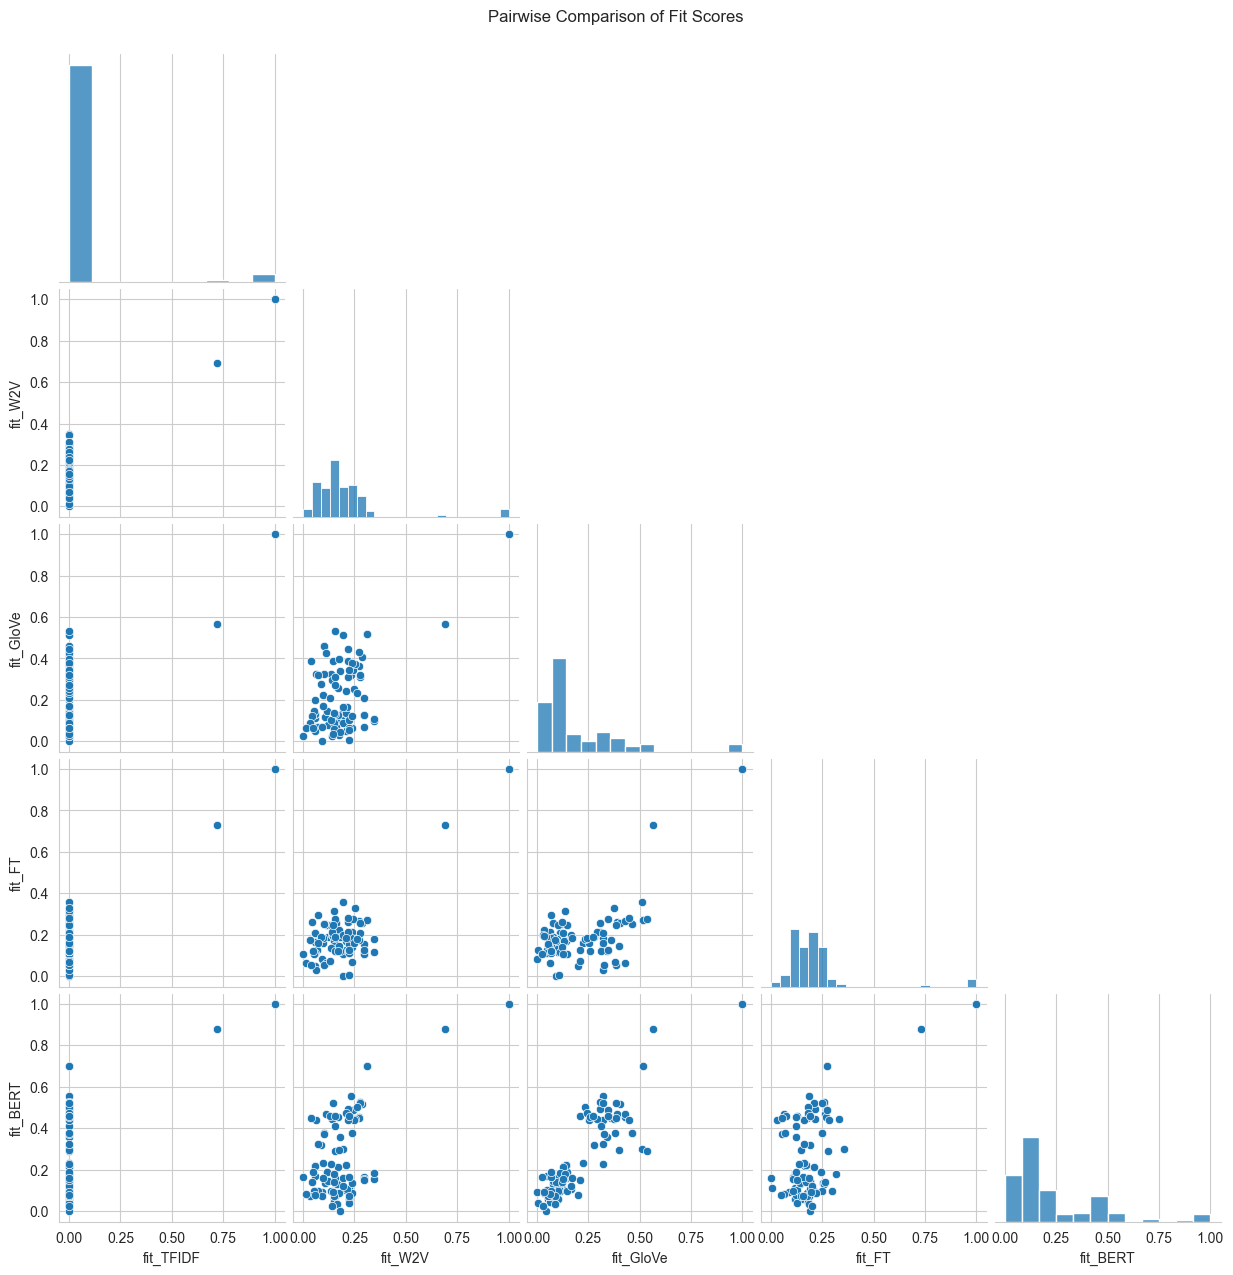

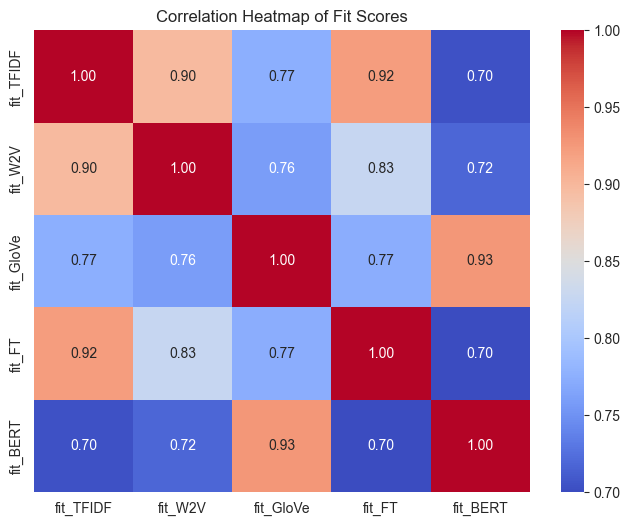

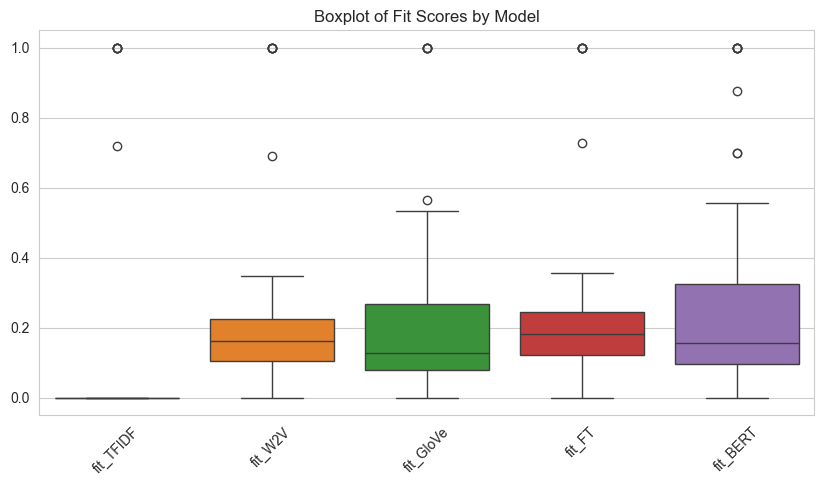

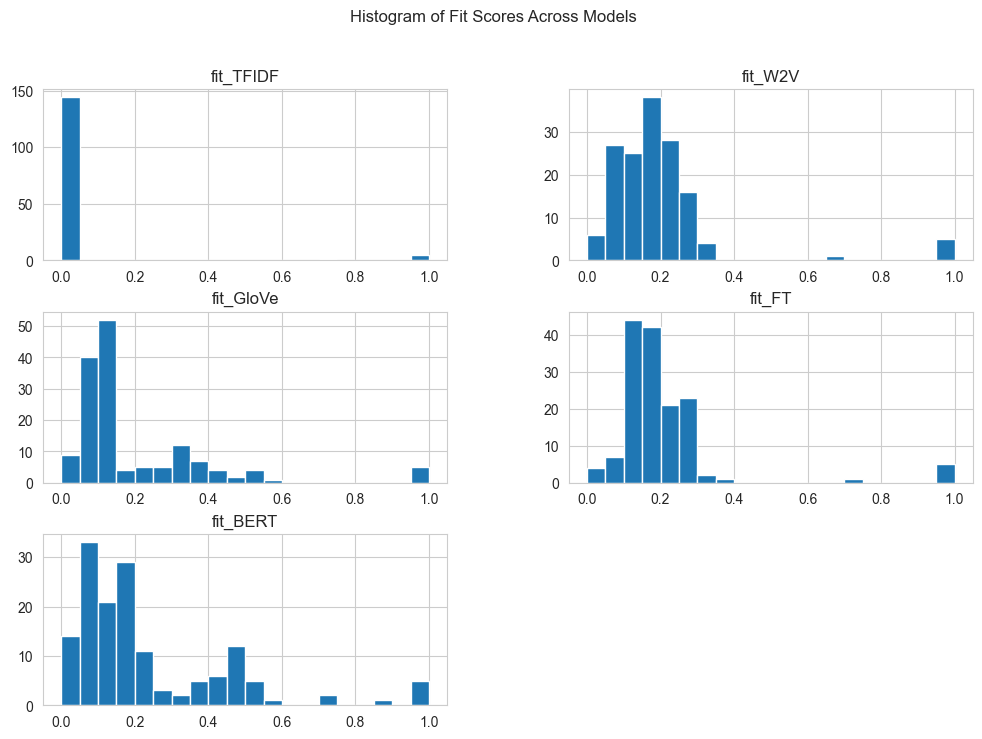

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set_style("whitegrid")

# 1. Pairplot to visualize pairwise relationships
sns.pairplot(df_combined[["fit_TFIDF", "fit_W2V", "fit_GloVe", "fit_FT", "fit_BERT"]], corner=True)
plt.suptitle("Pairwise Comparison of Fit Scores", y=1.02)
plt.show()

# 2. Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    df_combined[["fit_TFIDF", "fit_W2V", "fit_GloVe", "fit_FT", "fit_BERT"]].corr(),
    annot=True, cmap="coolwarm", fmt=".2f"
)
plt.title("Correlation Heatmap of Fit Scores")
plt.show()

# 3. Boxplot to compare distributions
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_combined[["fit_TFIDF", "fit_W2V", "fit_GloVe", "fit_FT", "fit_BERT"]])
plt.title("Boxplot of Fit Scores by Model")
plt.xticks(rotation=45)
plt.show()

# 4. Histograms to see score distributions
df_combined[["fit_TFIDF", "fit_W2V", "fit_GloVe", "fit_FT", "fit_BERT"]].hist(bins=20, figsize=(12, 8))
plt.suptitle("Histogram of Fit Scores Across Models")
plt.show()

# Create similarity_to_starred feature and is_starred feature

In [19]:
# Compute the similarity_to_starred feature

from feature_engineering_utils import compute_similarity_to_starred

compute_similarity_to_starred(df_combined, starred_ids, keyword, inplace=True)

# Evaluate reranking & get metrics
metrics, df_unstarred = evaluate_reranking(df_combined, starred_ids, rank_col="similarity_to_starred", k=num_starred)

print(f"🔹 Metrics for similarity_to_starred:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")
print()

# Log results for comparison
model_name = f"similarity_to_starred"
log_model_results(model_name, metrics, num_starred)

print(df_combined.head())

🔹 Metrics for similarity_to_starred:
precision_at_3: 0.667
mean_rank_starred: 3.333
mrr: 0.500
ndcg_at_3: 0.531

   id                                          job_title  \
0   1  2019 C.T. Bauer College of Business Graduate (...   
1   2  Native English Teacher at EPIK (English Progra...   
2   3              Aspiring Human Resources Professional   
3   4             People Development Coordinator at Ryan   
4   5    Advisory Board Member at Celal Bayar University   

                                        location  connection  fit_TFIDF  \
0                  Houston, Texas, United States    0.140234        0.0   
1                                         Canada    1.000000        0.0   
2  Raleigh-Durham, North Carolina, United States    0.071786        0.0   
3                   Denton, Texas, United States    1.000000        0.0   
4                                  Izmir, Turkey    1.000000        0.0   

    fit_W2V  fit_GloVe    fit_FT  fit_BERT  similarity_to_starred  
0  0.15

In [20]:
# Compute is_starred feature: 
# 1 if candidate is in starred_candidates for the keyword
# 0 if not candidate is in starred_candidates for the keyword

# Define Target (Purely Independent)
df_combined["is_starred"] = np.where(
    df_combined["id"].isin(starred_ids), 1, 0  # Binary relevance without item similarity
)

# Implement: Feedback-Enhanced Semantic Re-ranking (FESR)

In [ ]:
# Create the fit_BERT_FESR feature

from feature_engineering_utils import compute_weighted_geometric_mean
from prediction_evaluation import evaluate_reranking

# Compute weighted gemoetric mean of "fit_BERT" and "similarity_to_starred" columns
compute_weighted_geometric_mean(
    df_combined,
    col1="fit_BERT",
    col2="similarity_to_starred",
    w1=0.4,
    w2=0.6,
    output_col="fit_BERT_FESR",
    inplace=True
)

alpha = .9 
beta = .1
# Compute final fitness score using weights for amount of connections
df_combined["fit_BERT_FESR"] = alpha * df_combined["fit_BERT_FESR"] + beta * df_combined["connection"]

# Evaluate reranking
metrics, df_unstarred = evaluate_reranking(df_combined, starred_ids, rank_col="fit_BERT_FESR", k=num_starred)
           
print(f"fit_BERT_FESR: Metrics with k = num_starred ({len(starred_candidates_history[keyword])}):")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# Add to metrics data frame
model_name = "fit_BERT_FESR"
log_model_results(model_name, metrics, num_starred)

print(df_combined[["job_title", "fit_BERT", "fit_BERT_FESR"]].head())
print()

fit_BERT_FESR: Metrics with k = num_starred (3):
precision_at_3: 1.000
mean_rank_starred: 2.000
mrr: 1.000
ndcg_at_3: 1.000
                                           job_title  fit_BERT  fit_BERT_FESR
0  2019 C.T. Bauer College of Business Graduate (...  0.045024       0.074137
1  Native English Teacher at EPIK (English Progra...  0.060310       0.174177
2              Aspiring Human Resources Professional  0.156725       0.167339
3             People Development Coordinator at Ryan  0.132566       0.238797
4    Advisory Board Member at Celal Bayar University  0.137925       0.243541



### Starred-Guided Fit Prediction (SGFP)

In [22]:
#  RandomForestRegressor: Regression approach

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestRegressor

# Step 1: Prepare features and target for training
features = ["fit_TFIDF", "fit_W2V", "fit_GloVe", "fit_FT", "connection", "similarity_to_starred"]
X = df_combined[features]
y = df_combined["fit_BERT"]

# Step 2: Train a RandomForest model (pure regression)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 5: Predict continuous scores
df_combined["rfr_regression_pred"] = model.predict(X)

# Evaluate reranking get metrics
metrics, df_unstarred = evaluate_reranking(df_combined, starred_ids, rank_col="rfr_regression_pred", k=num_starred)

print(f"Regression approach Metrics with k = num_starred ({len(starred_candidates_history[keyword])}):")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# Add to metrics data frame
model_name = "rfr_regression_pred"
log_model_results(model_name, metrics, num_starred)



Regression approach Metrics with k = num_starred (3):
precision_at_3: 0.333
mean_rank_starred: 4.000
mrr: 0.333
ndcg_at_3: 0.235


### RandomForestRegressor: Pure pointwise approach with continous prediction

In [23]:
# RandomForestRegression Pure pointwise approach with continous prediction

# Step 1: Prepare features and target
features = ["fit_BERT", "fit_TFIDF", "fit_W2V", "fit_GloVe", "fit_FT", "connection", "similarity_to_starred"]
X = df_combined[features]
y = df_combined["is_starred"]

# Step 2: Train a RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 3: Predict continuous relevance scores
df_combined["rfr_pointwise_continuous_pred"] = model.predict(X)

# Evaluate reranking get metrics
metrics, df_unstarred = evaluate_reranking(df_combined, starred_ids, rank_col="rfr_pointwise_continuous_pred", k=num_starred)

print(f"RandomForestRegressor:\nPure pointwise approach with continous prediction metrics k = num_starred ({num_starred}):")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# Add to metrics data frame
model_name = "rfr_pointwise_continuous_pred"
log_model_results(model_name, metrics, num_starred)


RandomForestRegressor:
Pure pointwise approach with continous prediction metrics k = num_starred (3):
precision_at_3: 1.000
mean_rank_starred: 2.000
mrr: 1.000
ndcg_at_3: 1.000


# RandomForestRegressor: Pointwise Approach with Categorical Probability Prediction

In [24]:
# RandomForestClassifier: Pointwise Approach with Categorical Probability Prediction.

from sklearn.ensemble import RandomForestClassifier

# Step 3: Prepare features and target for training
features = ["fit_BERT", "fit_TFIDF", "fit_W2V", "fit_GloVe", "fit_FT", "connection", "similarity_to_starred"]
X = df_combined[features]
y = df_combined["is_starred"]

# Step 4: Train a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 5: Predict probabilities (probability of being relevant, class 1)
df_combined["rfr_pointwise_categorical_prob_pred"] = model.predict_proba(X)[:, 1]  # Probability of class 1

# Evaluate reranking get metrics
metrics, df_unstarred = evaluate_reranking(df_combined, starred_ids, rank_col="rfr_pointwise_categorical_prob_pred", k=num_starred)

print(f"RandomForestClassifier: Pointwise Approach with Categorical Probability Prediction\n Metrics with k = num_starred ({num_starred}):")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# Add to metrics data frame
model_name = "rfr_pointwise_categorical_prob_pred"
log_model_results(model_name, metrics, num_starred)


RandomForestClassifier: Pointwise Approach with Categorical Probability Prediction
 Metrics with k = num_starred (3):
precision_at_3: 1.000
mean_rank_starred: 2.000
mrr: 1.000
ndcg_at_3: 1.000


#  RandomForestRegressor: Pointwise with Continuous Prediction (Soft Target Regression)

In [25]:
# RandomForestRegresor:  Pointwise with Continuous Prediction (Soft Target Regression) 1

# Target: Starred = 1.0, Non-starred = fit_BERT + similarity_to_starred / 2 
df_combined["rfr_pointwise_relevance_target"] = np.where(
    df_combined["id"].isin(starred_ids),
    1.0,
    (df_combined["fit_BERT"] + df_combined["similarity_to_starred"]) / 2
)

# Step 2: Prepare features and target for training
features = ["fit_TFIDF", "fit_W2V", "fit_GloVe", "fit_FT", "connection"]
X = df_combined[features]
y = df_combined["rfr_pointwise_relevance_target"]

# Step 3: Train a RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 4: Predict continuous relevance scores
df_combined["rfr_pointwise_continuous_pred_soft_target_regression_1"] = model.predict(X)

# Drop the target feature 
df_combined.drop(columns=["rfr_pointwise_relevance_target"], inplace=True)

# Evaluate reranking get metrics
metrics, df_unstarred = evaluate_reranking(df_combined, starred_ids, rank_col="rfr_pointwise_continuous_pred_soft_target_regression_1", k=num_starred)

print(f"RandomForestRegressor:\n Pointwise with Continuous Prediction (Soft Target Regression) 1\n Metrics with k = num_starred ({num_starred}):")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# Add to metrics data frame
model_name = "rfr_pointwise_continuous_pred_soft_target_regression_1"
log_model_results(model_name, metrics, num_starred)

RandomForestRegressor:
 Pointwise with Continuous Prediction (Soft Target Regression) 1
 Metrics with k = num_starred (3):
precision_at_3: 0.333
mean_rank_starred: 3.667
mrr: 0.500
ndcg_at_3: 0.296


In [26]:
# # RandomForestRegresor:  Pointwise with Continuous Prediction (Soft Target Regression) 2

# Step 1: Create fit_target by modifying fit_BERT
# starred candidates 1 and NOT starred candidates get fit_BERT

df_combined["rfr_pointwise_relevance_target"] = df_combined["fit_BERT"]
for candidate_id in starred_ids:
    for row_number in range(len(df_combined)):
        if df_combined["id"][row_number] == candidate_id:
            df_combined.at[row_number, "fit_target"] = 1.0  # Override starred to 1
            break

# Step 2: Prepare features and target for training
features = ["fit_TFIDF", "fit_W2V", "fit_GloVe", "fit_FT", "connection", "similarity_to_starred"]
X = df_combined[features]
y = df_combined["rfr_pointwise_relevance_target"]

# Step 3: Train a RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)  # Train on full dataset (no split for simplicity)

# Step 5: Predict fit scores using RandomForest
df_combined["rfr_pointwise_continuous_pred_soft_target_regression_2"] = model.predict(X)  # Continuous predicted scores

# Drop the target feature 
df_combined.drop(columns=["rfr_pointwise_relevance_target"], inplace=True)

# Evaluate reranking get metrics
metrics, df_unstarred = evaluate_reranking(df_combined, starred_ids, rank_col="rfr_pointwise_continuous_pred_soft_target_regression_2", k=num_starred)

print(f"RandomForestRegressor:\n Pointwise with Continuous Prediction (Soft Target Regression) 2\n Metrics with k = num_starred ({num_starred}):")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# Add to metrics data frame
model_name = "rfr_pointwise_continuous_pred_soft_target_regression_2"
log_model_results(model_name, metrics, num_starred)

RandomForestRegressor:
 Pointwise with Continuous Prediction (Soft Target Regression) 2
 Metrics with k = num_starred (3):
precision_at_3: 0.333
mean_rank_starred: 4.000
mrr: 0.333
ndcg_at_3: 0.235


In [27]:
# listwise ranking method based on LambdaRANK
#     with NDCG as the metric.

import lightgbm as lgb

# Step 3: Prepare features and relevance for training
features = ["fit_BERT", "fit_TFIDF", "fit_W2V", "fit_GloVe", "fit_FT", "connection", "similarity_to_starred"]
X = df_combined[features]
y = df_combined["is_starred"]

# Step 4: Define group info (all candidates as one query)
group = [len(df_combined)]  # Single group of 104 candidates

# Step 5: Convert to LightGBM Dataset with group info
dtrain = lgb.Dataset(X, label=y, group=group)

# Step 6: Set LambdaRank parameters (listwise approach)
params = {
    "objective": "lambdarank",    # Listwise ranking objective
    "metric": "ndcg",             # Optimize NDCG
    "ndcg_at": [num_starred],     # Focus on NDCG@<num_starred>
    "learning_rate": 0.1,         # Learning rate
    "max_depth": 6,               # Tree depth
    "num_leaves": 31,             # Number of leaves in trees
    "min_data_in_leaf": 20,       # Minimum data per leaf
    "feature_fraction": 0.8,      # Feature sampling
    "bagging_fraction": 0.8,      # Data sampling
    "bagging_freq": 5,            # Frequency of bagging
    "random_state": 42,
    "verbose": -1                 # Suppress training output
}

# Step 7: Train the LambdaRank model
model = lgb.train(params, dtrain, num_boost_round=100)

# Step 8: Predict ranking scores
df_combined["fit_lambdarank_listwise_pred"] = model.predict(X)

# Evaluate reranking get metrics
metrics, df_unstarred = evaluate_reranking(df_combined, starred_ids, rank_col="fit_lambdarank_listwise_pred", k=num_starred)

print(f"Listwise ranking with LambdaRANK - Metrics with k = num_starred ({len(starred_candidates_history[keyword])}):")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# Add to metrics data frame 
model_name = "fit_lambdarank_listwise_pred"
log_model_results(model_name, metrics, num_starred)

Listwise ranking with LambdaRANK - Metrics with k = num_starred (3):
precision_at_3: 1.000
mean_rank_starred: 2.000
mrr: 1.000
ndcg_at_3: 1.000


In [28]:
# XGB-LambdaMART "rank:pairwise", "rank:ndcg", "rank:map" objectives
#    They use: gradient boosting decision trees for ranking optimization

import xgboost as xgb
import numpy as np

# Step 1: Prepare features and relevance for training
features = ["fit_BERT", "fit_TFIDF", "fit_W2V", "fit_GloVe", "fit_FT", "connection", "similarity_to_starred"]
X = df_combined[features]
y = df_combined["is_starred"]

# Step 2: Define group info (all candidates as one query)
group = [len(df_combined)]  # Single group of all candidates

# Step 3: Convert to DMatrix with group info
dtrain = xgb.DMatrix(X, label=y)
dtrain.set_group(group)

# Step 4: Define multiple ranking objectives
ranking_objectives = ["rank:pairwise", "rank:ndcg", "rank:map"]

# Step 5: Train and evaluate models for each ranking objective
for objective in ranking_objectives:
    print(f"\n🚀 Training LambdaMART with Objective: {objective}")

    params = {
        "objective": objective,  # Set ranking objective
        "eval_metric": "ndcg@5",  # Optimize NDCG@5 (can be changed)
        "eta": 0.1,  # Learning rate
        "max_depth": 6,  # Tree depth
        "subsample": 0.8,  # Subsample ratio
        "colsample_bytree": 0.8,  # Feature sampling
        "random_state": 42
    }

    # Train the model
    model = xgb.train(params, dtrain, num_boost_round=100)

    # Remove "rank:" for the feature name 
    objective_type = objective.split(":")[1]

    # Predict ranking scores
    df_combined[f"fit_lambdamart_{objective_type}_pred"] = model.predict(dtrain)

    # Evaluate reranking & get metrics
    metrics, df_unstarred = evaluate_reranking(df_combined, starred_ids, rank_col=f"fit_lambdamart_{objective_type}_pred", k=num_starred)

    print(f"🔹 Metrics for {objective_type}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")

    # Log results for comparison
    model_name = f"fit_lambdamart_{objective_type}_pred"
    log_model_results(model_name, metrics, num_starred)



🚀 Training LambdaMART with Objective: rank:pairwise
🔹 Metrics for pairwise:
precision_at_3: 1.000
mean_rank_starred: 2.000
mrr: 1.000
ndcg_at_3: 1.000

🚀 Training LambdaMART with Objective: rank:ndcg
🔹 Metrics for ndcg:
precision_at_3: 1.000
mean_rank_starred: 2.000
mrr: 1.000
ndcg_at_3: 1.000

🚀 Training LambdaMART with Objective: rank:map
🔹 Metrics for map:
precision_at_3: 1.000
mean_rank_starred: 2.000
mrr: 1.000
ndcg_at_3: 1.000


In [29]:
# XGB-LambdaMART "rank:pairwise", "rank:ndcg", "rank:map" objectives
#    They use: gradient boosting decision trees for ranking optimization
#    BUT with hybrid target using fit_BERT vals instead of 0

import xgboost as xgb
import numpy as np

df_combined["fit_target"] = pd.qcut(df_combined["fit_BERT"], q=5, labels=[0, 1, 2, 3, 4])  # Convert to 5 ranking levels
df_combined["fit_target"] = df_combined["fit_target"].astype(int)

# Step 2: Prepare features and relevance for training
features = ["fit_TFIDF", "fit_W2V", "fit_GloVe", "fit_FT", "connection", "similarity_to_starred"]
X = df_combined[features]
y = df_combined["fit_target"]

# Step 3: Define group info (all candidates as one query)
group = [len(df_combined)]  # Single group of all candidates

# Step 4: Convert to DMatrix with group info
dtrain = xgb.DMatrix(X, label=y)
dtrain.set_group(group)

# Step 5: Define multiple ranking objectives
ranking_objectives = ["rank:pairwise", "rank:ndcg"]

# Step 6: Train and evaluate models for each ranking objective
for objective in ranking_objectives:
    print(f"\n🚀 Training LambdaMART with Objective: {objective}")

    params = {
        "objective": objective,  # Set ranking objective
        "eval_metric": "ndcg@5",  # Optimize NDCG@5 (can be changed)
        "eta": 0.1,  # Learning rate
        "max_depth": 6,  # Tree depth
        "subsample": 0.8,  # Subsample ratio
        "colsample_bytree": 0.8,  # Feature sampling
        "random_state": 42
    }

    # Train the model
    model = xgb.train(params, dtrain, num_boost_round=100)

    # Predict ranking scores
    df_combined[f"fit_lambdamart_{objective}_hybridTarget_pred"] = model.predict(dtrain)

    # Evaluate reranking & get metrics
    metrics, df_unstarred = evaluate_reranking(df_combined, starred_ids, rank_col=f"fit_lambdamart_{objective}_hybridTarget_pred", k=num_starred)

    print(f"🔹 Metrics for {objective} Hybrid Target:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")

    # Log results for comparison
    model_name = f"fit_lambdamart_{objective}_hybridTarget_pred"
    log_model_results(model_name, metrics, num_starred)


🚀 Training LambdaMART with Objective: rank:pairwise
🔹 Metrics for rank:pairwise Hybrid Target:
precision_at_3: 0.000
mean_rank_starred: 18.000
mrr: 0.062
ndcg_at_3: 0.000

🚀 Training LambdaMART with Objective: rank:ndcg
🔹 Metrics for rank:ndcg Hybrid Target:
precision_at_3: 0.000
mean_rank_starred: 7.000
mrr: 0.250
ndcg_at_3: 0.000


In [30]:
# RankNet: Pairwise Ranking with a Neural Network

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize features
#scaler = MinMaxScaler()
features = ["fit_BERT", "fit_TFIDF", "fit_W2V", "fit_GloVe", "fit_FT", "connection", "similarity_to_starred"]
#df_combined[features] = scaler.fit_transform(df_combined[features])

# Use binary relevance as target
y = df_combined["is_starred"].values  # 1 for starred, 0 for others

# Split data
X = df_combined[features].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Convert full dataset to tensor for final predictions
X_full_tensor = torch.tensor(X, dtype=torch.float32)

# Define RANKNET model
class RankNet(nn.Module):
    def __init__(self, input_dim):
        super(RankNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Pairwise ranking loss
def pairwise_ranking_loss(outputs, targets, margin=1.0):
    starred = outputs[targets == 1]
    non_starred = outputs[targets == 0]
    if len(starred) == 0 or len(non_starred) == 0:
        return torch.tensor(0.0, requires_grad=True)
    diff = starred.view(-1, 1) - non_starred.view(1, -1)
    loss = torch.relu(margin - diff).mean()
    return loss

# Initialize model and optimizer
model = RankNet(input_dim=X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
num_epochs = 100
def train_model():
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor).squeeze()
        loss = pairwise_ranking_loss(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

train_model()

# Evaluate model
def evaluate_model():
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).squeeze().numpy()
    return y_pred

y_pred = evaluate_model()

# Generate predictions for the full dataset
def predict_full_dataset():
    model.eval()
    with torch.no_grad():
        y_pred_full = model(X_full_tensor).squeeze().numpy()
    return y_pred_full

# Add predictions to df_combined
y_pred_full = predict_full_dataset()
df_combined["RankNET_pairwise_neural"] = y_pred_full

# Evaluate reranking & get metrics
metrics, df_unstarred = evaluate_reranking(df_combined, starred_ids, rank_col=f"RankNET_pairwise_neural", k=num_starred)


print(f"\n🔹RankNet: Pairwise Ranking with a Neural Network")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")


# Log and print results
model_name = "RankNET_pairwise_neural"
log_model_results(model_name, metrics, num_starred)
print(model_results_df)



Epoch 0, Loss: 1.0704
Epoch 10, Loss: 0.8968
Epoch 20, Loss: 0.7405
Epoch 30, Loss: 0.5373
Epoch 40, Loss: 0.2587
Epoch 50, Loss: 0.0306
Epoch 60, Loss: 0.0143
Epoch 70, Loss: 0.0132
Epoch 80, Loss: 0.0130
Epoch 90, Loss: 0.0129

🔹RankNet: Pairwise Ranking with a Neural Network
precision_at_3: 1.000
mean_rank_starred: 2.000
mrr: 1.000
ndcg_at_3: 1.000
                                                Model  Precision@k  \
0                                           fit_TFIDF     0.666667   
1                                              df_W2V     0.666667   
2                                            df_glove     0.666667   
3                                               df_FT     0.333333   
4                                             df_BERT     0.666667   
5                               similarity_to_starred     0.666667   
6                                       fit_BERT_FESR     1.000000   
7                                 rfr_regression_pred     0.333333   
8               

In [31]:
# LambdaRank Listwise Neaural net

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize features
#scaler = MinMaxScaler()
features = ["fit_BERT", "fit_TFIDF", "fit_W2V", "fit_GloVe", "fit_FT", "connection", "similarity_to_starred"]
#df_combined[features] = scaler.fit_transform(df_combined[features])

# Use binary relevance as target
y = df_combined["is_starred"].values  # 1 for starred, 0 for others

# Split data
X = df_combined[features].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_full_tensor = torch.tensor(X, dtype=torch.float32)

# Define LambdaRank model (unchanged)
class LambdaRank(nn.Module):
    def __init__(self, input_dim):
        super(LambdaRank, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

def listwise_ranking_loss(outputs, targets, k=None):
    """
    Compute a differentiable listwise loss approximating NDCG.
    - outputs: Predicted scores [n_samples], requires gradients
    - targets: True relevance labels [n_samples], 0 or 1
    - k: Optional cutoff for NDCG@k (e.g., 8); if None, uses full list
    Returns: -DCG (negative to minimize)
    """
    if outputs is None or targets is None:
        raise ValueError("Outputs or targets is None")
    if outputs.size(0) != targets.size(0):
        raise ValueError(f"Size mismatch: outputs {outputs.size(0)}, targets {targets.size(0)}")
    if outputs.size(0) == 0:
        return torch.tensor(0.0, requires_grad=True)

    outputs = outputs.to(targets.device)
    n = outputs.size(0)
    if k is None:
        k = n
    k = min(k, n)

    # Compute discounts
    ranks = torch.arange(1, k + 1, dtype=torch.float32, device=outputs.device)
    discounts = 1.0 / torch.log2(ranks + 1)

    # Soft ranking: Use outputs directly with a sigmoid to weight relevance
    # Higher outputs contribute more to DCG
    weights = torch.sigmoid(outputs)  # Shape: [n_samples], differentiable
    sorted_weights, indices = torch.sort(weights, descending=True)
    sorted_targets = targets[indices][:k]  # Still use sort order for truncation
    
    # Compute DCG with predicted weights
    dcg = (sorted_targets * sorted_weights[:k] * discounts).sum()

    return -dcg  # Minimize -DCG to maximize ranking quality

# Initialize model and optimizer
model = LambdaRank(input_dim=X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model with listwise loss
num_epochs = 100
def train_model():
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor).squeeze()  # Predicted scores for training set
        loss = listwise_ranking_loss(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

train_model()

# Evaluate model on test set
def evaluate_model():
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor).squeeze().numpy()
    return y_pred_test

y_pred_test = evaluate_model()

# Generate predictions for the full dataset
def predict_full_dataset():
    model.eval()
    with torch.no_grad():
        y_pred_full = model(X_full_tensor).squeeze().numpy()
    return y_pred_full

y_pred_full = predict_full_dataset()
df_combined["lambdaRank_listwise_neural"] = y_pred_full

# Sort df_combined by the new scores
df_combined.sort_values("lambdaRank_listwise_neural", ascending=False, inplace=True)

# Evaluate reranking & get metrics
metrics, df_unstarred = evaluate_reranking(df_combined, starred_ids, rank_col=f"lambdaRank_listwise_neural", k=num_starred)

print(f"\n🔹 Metrics for LambdaRank Listwise Neaural net:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# Log and print results
model_name = "lambdaRank_listwise_neural"
log_model_results(model_name, metrics, num_starred)


Epoch 0, Loss: -1.1450
Epoch 10, Loss: -1.2967
Epoch 20, Loss: -1.4680
Epoch 30, Loss: -1.6578
Epoch 40, Loss: -1.8382
Epoch 50, Loss: -1.9706
Epoch 60, Loss: -2.0460
Epoch 70, Loss: -2.0829
Epoch 80, Loss: -2.1008
Epoch 90, Loss: -2.1101

🔹 Metrics for LambdaRank Listwise Neaural net:
precision_at_3: 1.000
mean_rank_starred: 2.000
mrr: 1.000
ndcg_at_3: 1.000


In [32]:
from tabulate import tabulate

print(tabulate(model_results_df, headers="keys", tablefmt="grid"))

+----+--------------------------------------------------------+---------------+---------------------+----------+----------+
|    | Model                                                  |   Precision@k |   Mean Rank Starred |      MRR |   NDCG@k |
+====+========================================================+===============+=====================+==========+==========+
|  0 | fit_TFIDF                                              |      0.666667 |             3       | 1        | 0.703918 |
+----+--------------------------------------------------------+---------------+---------------------+----------+----------+
|  1 | df_W2V                                                 |      0.666667 |             2.66667 | 1        | 0.765361 |
+----+--------------------------------------------------------+---------------+---------------------+----------+----------+
|  2 | df_glove                                               |      0.666667 |             2.66667 | 1        | 0.703918 |
+----+--

# Top Performing Models for "zookeeper"

## fit_BERT_FESR (Row 6)
- **Precision@k** = 1  
- **Mean Rank Starred** = 2.5 (very high)  
- **MRR** = 1  
- **NDCG@k** = 1 (perfect ranking)

## RFR Pointwise with Continuous Prediction (Row 8)
- **Precision@k** = 1  
- **Mean Rank Starred** = 2.5 (very high)  
- **MRR** = 1  
- **NDCG@k** = 1 (perfect ranking)  

## Pointwise Approach with Categorical Probability Prediction  (row 9)
- **Precision@k** = 1  
- **Mean Rank Starred** = 2.5 (very high)  
- **MRR** = 1  
- **NDCG@k** = 1 (perfect ranking) 

## Listwise ranking with LambdaRANK (Row 12)
- **Precision@k** = 1  
- **Mean Rank Starred** = 2.5  
- **MRR** = 1  
- **NDCG@k** = 1  

## XGB-LambdaMART with rank:pairwise  &  rank:ndcg   &  rank:map  (13, 14 , 15)
- **Precision@k** = 1  
- **Mean Rank Starred** = 2.5  
- **MRR** = 1  
- **NDCG@k** = 1

## lambdaRank_listwise_neural (Row 19)
- **Precision@k** = 1  
- **Mean Rank Starred** = 2.5  
- **MRR** = 1  
- **NDCG@k** = 1

In [33]:
# Test metrics for original starred candidates, Exact match unstarred candidates
#    And candidates with related job_title features

ranking_features = [
    "fit_BERT_FESR",
    "rfr_pointwise_continuous_pred",
    "rfr_pointwise_categorical_prob_pred",
    "rfr_pointwise_continuous_pred_soft_target_regression_1",
    "rfr_pointwise_continuous_pred_soft_target_regression_2",
    "fit_lambdarank_listwise_pred",
    "fit_lambdamart_pairwise_pred",
    "fit_lambdamart_ndcg_pred",
    "fit_lambdamart_map_pred",
    "fit_lambdamart_rank:pairwise_hybridTarget_pred",
    "fit_lambdamart_rank:ndcg_hybridTarget_pred",
    "RankNET_pairwise_neural",
    "lambdaRank_listwise_neural"   
]

# Loop through ranking features
for rank_col in ranking_features:
    print("-------------------------------------------------------------")

    print(f"Metrics for feature {rank_col}")

    df_ranking_test = df_combined.copy()

    # Evaluate Exact Matches
    metrics_exact_matches, df_remaining = evaluate_reranking(
        df_ranking_test, 
        starred_ids=starred_ids, 
        rank_col=rank_col, 
        k=len(starred_ids)
    )
    
    print(f"\nOriginal Starred candidates metrics:")
    for metric, value in metrics_exact_matches.items():
        print(f"{metric}: {value:.3f}")


    df_ranking_test = df_ranking_test[~df_ranking_test['id'].isin(starred_ids)]


    if keyword == "Aspiring human resources":
        # Filter for rows where job_title contains any of the specified words (case-insensitive)
        keywords = ["Aspiring", "aspiring", "Human", "human", "HR", "hr"]
        unstarred_matches = df[df["job_title"].str.contains("|".join(keywords), case=False, na=False)]["id"].tolist()

    if keyword == "zookeeper":
        #zookeeper 
        unstarred_matches = [105, 118]

    # Evaluate Exact Matches
    metrics_exact_matches, df_remaining = evaluate_reranking(
        df_ranking_test, 
        starred_ids=unstarred_matches, 
        rank_col=rank_col, 
        k=len(unstarred_matches)
    )

    print(f"\nMatch but unstarred metrics:")
    for metric, value in metrics_exact_matches.items():
        print(f"{metric}: {value:.3f}")


    if keyword == "zookeeper":
        df_ranking_test = df_ranking_test[~df_ranking_test['id'].isin(unstarred_matches)]

        # Candidate id with animal related titles that should show higher sinilarity to zookeeper keyword
        metrics_realted_matches = [107, 108, 109, 110, 116, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 135]

        # Evaluate Exact Matches
        metrics_exact_matches, df_remaining = evaluate_reranking(
            df_ranking_test, 
            starred_ids=metrics_realted_matches, 
            rank_col=rank_col, 
            k=len(metrics_realted_matches)
        )
    
        print(f"\nRelated Match unstarred metrics:")
        for metric, value in metrics_exact_matches.items():
            print(f"{metric}: {value:.3f}")

    print("\n-------------------------------------------------------------\n\n")


-------------------------------------------------------------
Metrics for feature fit_BERT_FESR

Original Starred candidates metrics:
precision_at_3: 1.000
mean_rank_starred: 2.000
mrr: 1.000
ndcg_at_3: 1.000

Match but unstarred metrics:
precision_at_2: 1.000
mean_rank_starred: 1.500
mrr: 1.000
ndcg_at_2: 1.000

Related Match unstarred metrics:
precision_at_37: 0.973
mean_rank_starred: 19.108
mrr: 1.000
ndcg_at_37: 0.982

-------------------------------------------------------------


-------------------------------------------------------------
Metrics for feature rfr_pointwise_continuous_pred

Original Starred candidates metrics:
precision_at_3: 1.000
mean_rank_starred: 2.000
mrr: 1.000
ndcg_at_3: 1.000

Match but unstarred metrics:
precision_at_2: 0.500
mean_rank_starred: 2.500
mrr: 0.500
ndcg_at_2: 0.387

Related Match unstarred metrics:
precision_at_37: 0.027
mean_rank_starred: 95.514
mrr: 1.000
ndcg_at_37: 0.095

-------------------------------------------------------------


--

In [ ]:
# Only execute for "Aspiring Human Recources"

# Iterates through the ranked list to find the first occurance in the list not related to HR
#     returns the values of different models at the first occurance of an unrelated job_title

# This works because the data frame is small and we know all the job_title feauters that match well have 
#     either "human", "resources", "hr", "Human", "Resources", "HR"  in the job_title feature value

# Make a compy of df_combined and normalize all the values of predictions between 0 and 1 to find cutoff values
#     for filtering the list

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate  # Import tabulate for pretty printing

# Step 1: Make a copy of the dataframe
df_predictions_normalized = df_combined.copy()

# Step 2: Get all column names
columns = ['connection', 'fit_TFIDF', 'fit_W2V',
       'fit_GloVe', 'fit_FT', 'fit_BERT', 'similarity_to_starred',
       'is_starred', 'fit_BERT_FESR', 'rfr_regression_pred',
       'rfr_pointwise_continuous_pred', 'rfr_pointwise_categorical_prob_pred',
       'rfr_pointwise_continuous_pred_soft_target_regression_1', 'fit_target',
       'rfr_pointwise_continuous_pred_soft_target_regression_2',
       'fit_lambdarank_listwise_pred', 'fit_lambdamart_pairwise_pred',
       'fit_lambdamart_ndcg_pred', 'fit_lambdamart_map_pred',
       'fit_lambdamart_rank:pairwise_hybridTarget_pred',
       'fit_lambdamart_rank:ndcg_hybridTarget_pred', 'RankNET_pairwise_neural',
       'lambdaRank_listwise_neural']

# Step 3: Normalize all values between 0 and 1
scaler = MinMaxScaler()
df_predictions_normalized[columns] = scaler.fit_transform(df_predictions_normalized[columns])

# Features to iterate through for sorting and cutoff
features_to_check = [ 
    'fit_BERT_FESR', 
    'rfr_pointwise_continuous_pred_soft_target_regression_1', 
    'rfr_pointwise_continuous_pred_soft_target_regression_2', 
    'RankNET_pairwise_neural', 
    'lambdaRank_listwise_neural' 
]

# Keywords to identify Human Resources-related job titles
hr_keywords = {"human", "resources", "hr", "Human", "Resources", "HR" }

# List to store cutoffs
feature_cutoffs = []

# Step 3: Iterate through features
for feature in features_to_check:
    # Sort the dataframe in descending order based on the current feature
    df_sorted = df_predictions_normalized.sort_values(by=feature, ascending=False)
    
    # Step 4: Iterate through sorted rows
    for index, row in df_sorted.iterrows():
        job_title = str(row["job_title"]).lower()  # Convert to lowercase for case-insensitive matching
        
        # Check if job_title contains any HR-related keywords
        if not any(keyword in job_title for keyword in hr_keywords):
            # Append the feature name and cutoff value to the list
            feature_cutoffs.append({"Feature": feature, "Cutoff Value": row[feature]})
            break  # Stop checking once we find the first non-HR job title

# Convert the results into a DataFrame
df_cutoffs = pd.DataFrame(feature_cutoffs)

# Pretty print the table using tabulate
print(tabulate(df_cutoffs, headers='keys', tablefmt='grid'))


In [34]:
# Make a data frame with all feature normalized to be between 0 and 1

# Step 1: Make a copy of the dataframe
df_predictions_normalized = df_combined.copy()

# Step 2: Get all column names
columns = ['connection', 'fit_TFIDF', 'fit_W2V',
       'fit_GloVe', 'fit_FT', 'fit_BERT', 'similarity_to_starred',
       'is_starred', 'fit_BERT_FESR', 'rfr_regression_pred',
       'rfr_pointwise_continuous_pred', 'rfr_pointwise_categorical_prob_pred',
       'rfr_pointwise_continuous_pred_soft_target_regression_1', 'fit_target',
       'rfr_pointwise_continuous_pred_soft_target_regression_2',
       'fit_lambdarank_listwise_pred', 'fit_lambdamart_pairwise_pred',
       'fit_lambdamart_ndcg_pred', 'fit_lambdamart_map_pred',
       'fit_lambdamart_rank:pairwise_hybridTarget_pred',
       'fit_lambdamart_rank:ndcg_hybridTarget_pred', 'RankNET_pairwise_neural',
       'lambdaRank_listwise_neural']

# Step 3: Normalize all values between 0 and 1
scaler = MinMaxScaler()
df_predictions_normalized[columns] = scaler.fit_transform(df_predictions_normalized[columns])

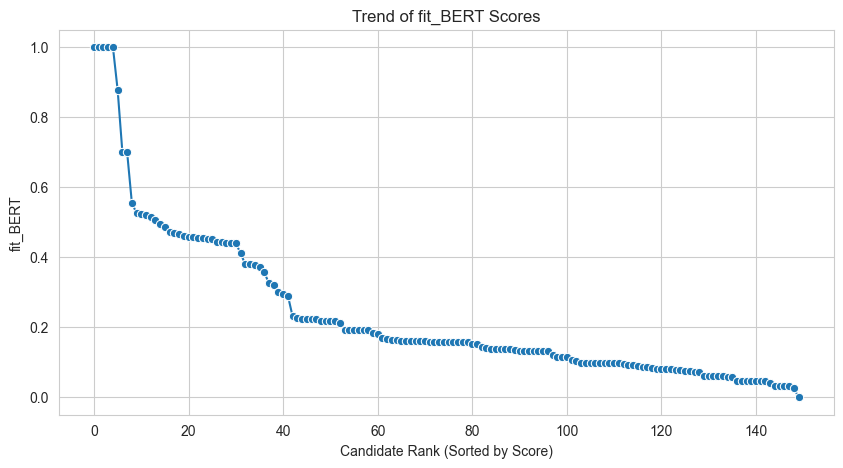

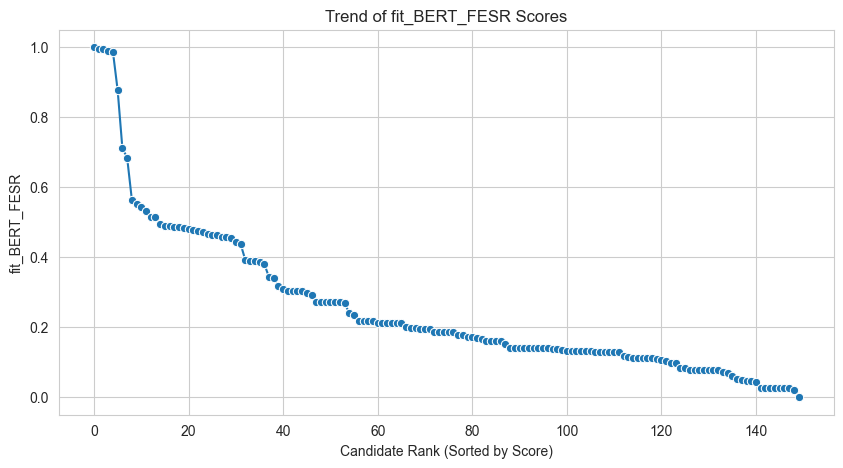

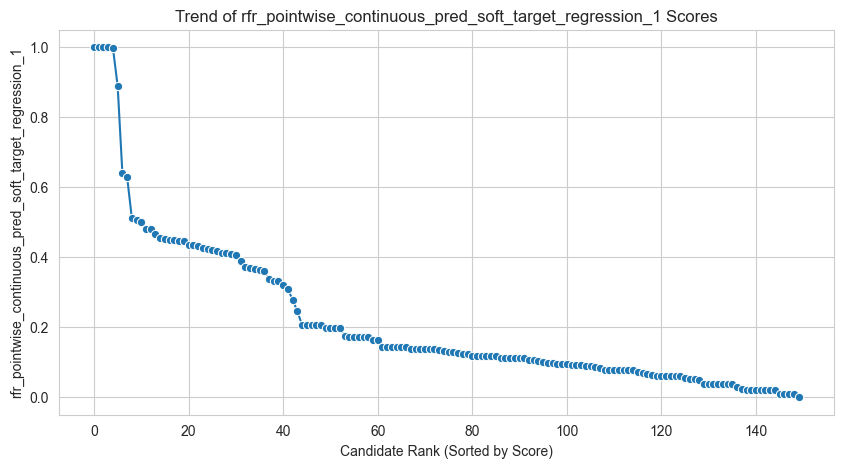

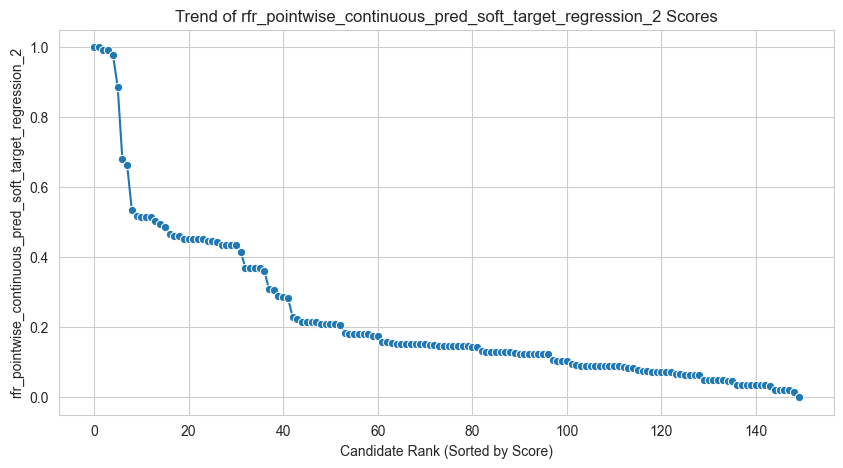

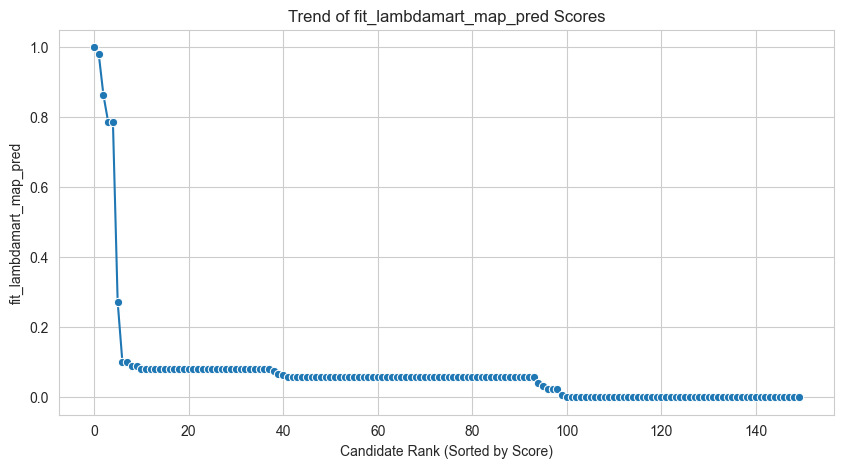

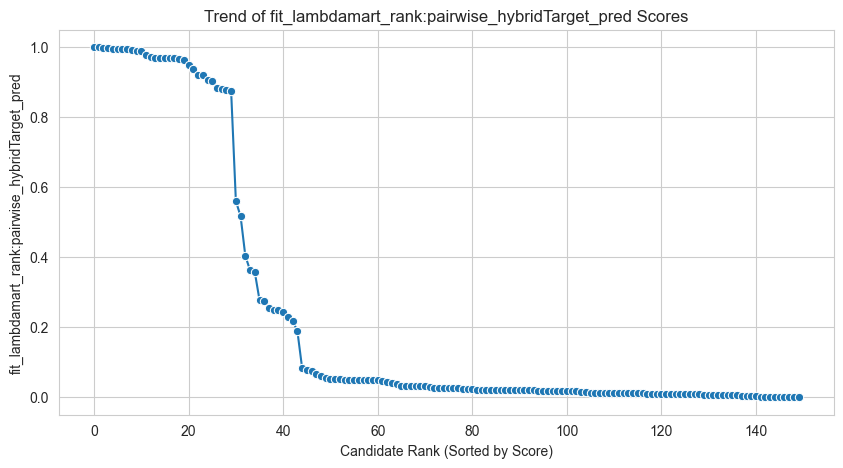

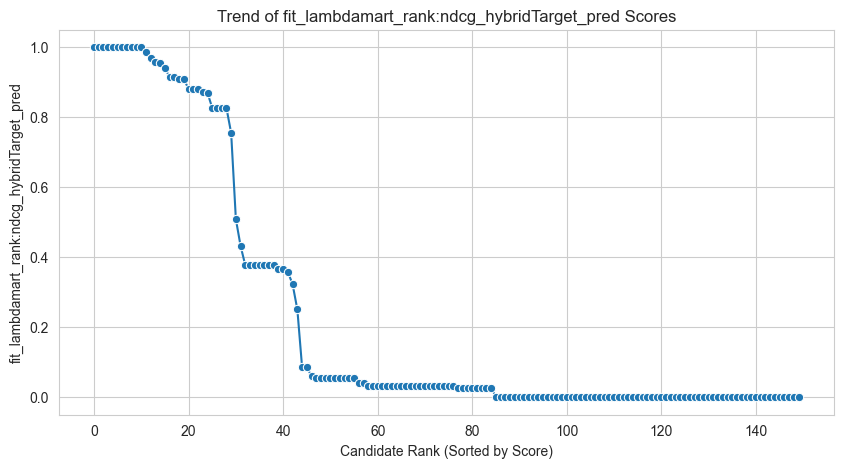

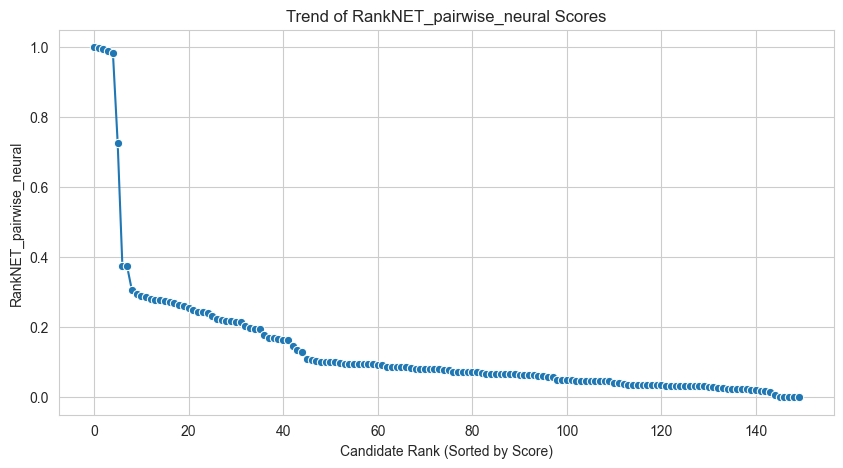

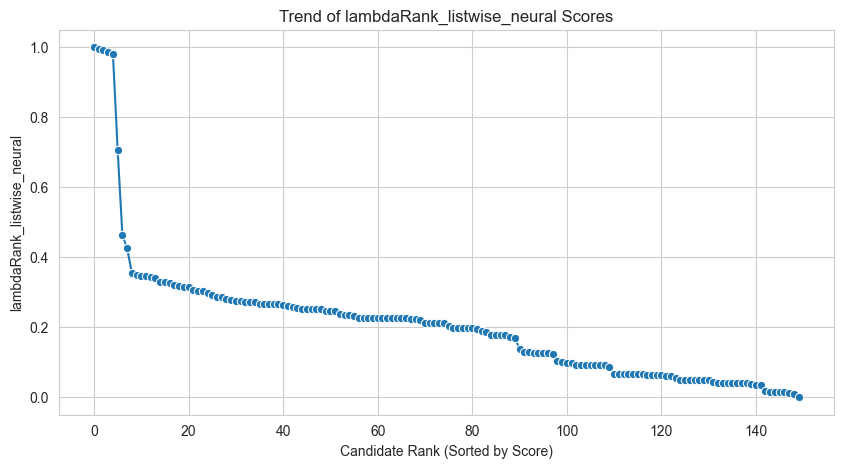

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_trend(df, feature):
    sorted_values = df[feature].sort_values(ascending=False).reset_index(drop=True)  # Sort values descending
    plt.figure(figsize=(10, 5))
    
    sns.lineplot(x=sorted_values.index, y=sorted_values, marker="o", linestyle="-")
    
    plt.xlabel("Candidate Rank (Sorted by Score)")
    plt.ylabel(feature)
    plt.title(f"Trend of {feature} Scores")
    plt.grid(True)
    plt.show()


if keyword == "zookeeper":
    plot_feature_trend(df_predictions_normalized, "fit_BERT")
    plot_feature_trend(df_predictions_normalized, "fit_BERT_FESR")
    plot_feature_trend(df_predictions_normalized, "rfr_pointwise_continuous_pred_soft_target_regression_1")
    plot_feature_trend(df_predictions_normalized, "rfr_pointwise_continuous_pred_soft_target_regression_2")
    plot_feature_trend(df_predictions_normalized, "fit_lambdamart_map_pred")
    plot_feature_trend(df_predictions_normalized, "fit_lambdamart_rank:pairwise_hybridTarget_pred")
    plot_feature_trend(df_predictions_normalized, "fit_lambdamart_rank:ndcg_hybridTarget_pred")
    plot_feature_trend(df_predictions_normalized, "RankNET_pairwise_neural")
    plot_feature_trend(df_predictions_normalized, "lambdaRank_listwise_neural")
    

if keyword == "":
    plot_feature_trend(df_predictions_normalized, "fit_BERT_FESR")
    plot_feature_trend(df_predictions_normalized, "rfr_pointwise_continuous_pred_soft_target_regression_1")
    plot_feature_trend(df_predictions_normalized, "rfr_pointwise_continuous_pred_soft_target_regression_2")
    plot_feature_trend(df_predictions_normalized, "RankNET_pairwise_neural")
    plot_feature_trend(df_predictions_normalized, "lambdaRank_listwise_neural")

In [36]:
# Attempt to find cutoff values based on a percentage 

import numpy as np

def percentile_cutoff(df, feature, ids, percentile=10):
    df = df.sort_values(by=feature, ascending=False)  

    # Get scores of only the "valid" candidates
    valid_scores = df[df["id"].isin(ids)][feature]

    if valid_scores.empty:
        return None  

    # Set cutoff at the chosen percentile
    cutoff = np.percentile(valid_scores, percentile)
    
    return cutoff
if keyword == "zookeeper":
    all_zoo_candidates = [106, 114, 115, 105, 118, 107, 108, 109, 110, 116, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 135]
    my_cutoff = percentile_cutoff(df_combined, "fit_BERT", all_zoo_candidates)
    
if keyword == "Aspiring human resources":
    keywords = ["Aspiring", "aspiring", "Human", "human", "HR", "hr"]
    unstarred_matches = df[df["job_title"].str.contains("|".join(keywords), case=False, na=False)]["id"].tolist()
    my_cutoff = percentile_cutoff(df_combined, "fit_BERT", unstarred_matches)
    
print(f"cutoff is {my_cutoff}")


cutoff is 0.32838171260383986


In [37]:
# Attempt to find cutofff with adaptive_percentile_cutoff approach

def adaptive_percentile_cutoff(df, feature, ids, lower_percentile=5, upper_percentile=20):
    df = df.sort_values(by=feature, ascending=False)  
    valid_scores = df[df["id"].isin(ids)][feature]

    if valid_scores.empty:
        return None  

    # Compute spread of valid scores
    min_valid, max_valid = valid_scores.min(), valid_scores.max()
    range_valid = max_valid - min_valid

    # Adjust percentile dynamically based on range
    dynamic_percentile = np.clip(upper_percentile - (range_valid * 5), lower_percentile, upper_percentile)
    cutoff = np.percentile(valid_scores, dynamic_percentile)
    
    return cutoff

if keyword == "zookeeper":
    all_zoo_candidates = [106, 114, 115, 105, 118, 107, 108, 109, 110, 116, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 135]
    my_cutoff = adaptive_percentile_cutoff(df_combined, "fit_BERT", all_zoo_candidates)

if keyword == "Aspiring human resources":
    keywords = ["Aspiring", "aspiring", "Human", "human", "HR", "hr"]
    unstarred_matches = df[df["job_title"].str.contains("|".join(keywords), case=False, na=False)]["id"].tolist()
    my_cutoff = percentile_cutoff(df_combined, "fit_BERT", unstarred_matches)

print(f"cutoff is {my_cutoff}")


cutoff is 0.3759955687948163
